Try to make each cell run independently

In [1]:
%matplotlib inline
import numpy as np
from astropy.table import Table
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from tqdm import *
import os

# yztools is another repo at github.com/yzhenggit
from yztools.vhelio2vlsr import vhelio2vlsr_Westmeier
from yztools.bin_spec import bin_spec

### Sect 2: Set SNR>=5 limit to select those good QSOs to use 

In [2]:
qtb = Table.read('tables/SiIV_QSO_visuallygood290.txt', format='ascii')
specdir = 'cos-gal_mast_hlsp/spectra'

In [3]:
from yzSpec.get_snr import get_snr
snr_cont = np.zeros(len(qtb))
snr_flux = np.zeros(len(qtb))

for iq in tqdm(range(len(qtb))):
    qname = qtb['ID'][iq]
    qsodir = '%s/%s/'%(specdir, qname.lower())
    for ifile in os.listdir(qsodir):
        if ifile[-7:] == 'fits.gz' and 'g130m' in ifile:
            specfile = ifile
            break
    # print(qname, specfile)
    data = fits.getdata(qsodir+specfile)
    snrss= get_snr(data, 1394, 1401, has_continuum=True)
    snr_flux[iq] = snrss[0]
    snr_cont[iq] = snrss[1]

# next time, just read in the table, no need to run this cell again. 
# np.save('tables/fig1/fig1_visuallygood290_rawsnrcut.npy', np.asarray([snr_flux, snr_cont]))

100%|██████████| 290/290 [00:09<00:00, 30.34it/s]


In [4]:
# data = np.load('tables/fig1/fig1_visuallygood290_rawsnrcut.npy')
#snr_flux = data[0]
#snr_cont = data[1]

In [5]:
snr_limit = 5
qtb_good = qtb[snr_cont >= snr_limit]
snr_good = snr_cont[snr_cont >= snr_limit]

qtb_bad = qtb[snr_cont<snr_limit]
snr_bad = snr_cont[snr_cont<snr_limit]
print('SNR limit at %d, good %d, bad %d'%(snr_limit, len(qtb_good), len(qtb_bad)))

SNR limit at 5, good 132, bad 158


Find those sightlines with SiIV1393 saturated 

In [6]:
# check the continuum fitting for every QSO 
tag_good = np.zeros(len(qtb_good)) # 0 for resolved, 1 for sat in 1393
for iq, iqtb in tqdm(enumerate(qtb_good)):  # only deal with those with SNR>=5 
    qname = iqtb['ID']
    qsodir = '%s/%s/linedata_uv/'%(specdir, qname.lower())
    for ifile in os.listdir(qsodir):
        if 'si-iv-1393' in ifile:
            specfile = ifile
            break
            
    data = fits.getdata(qsodir+specfile)
    vcorr = vhelio2vlsr_Westmeier(0, iqtb['l'], iqtb['b'], doradec=False)
    vel = data['VELOCITY']+vcorr
    nflux = data['NORMFLUX']
    nerr = data['NORMERR']
    ind = np.all([vel>=-110, vel<=110], axis=0)
    vel = vel[ind]
    nflux = nflux[ind]
    
    xx, yy = bin_spec(vel, nflux, 3)
    fmin = np.nanmin(yy)
    
    if fmin <= 0.1: 
        tag = 1
        print(iq, qname, fmin)
        tag_good[iq] = tag

44it [00:00, 20.09it/s]

15 3C273 0.08730045209328334


75it [00:00, 35.92it/s]

54 MRK841 0.0946748120089372
62 PDS456 0.010543085324267546


132it [00:01, 127.93it/s]


Calculate the NAOD within +/-100 km/s for the doublet, and compare the difference 

In [7]:
import numpy as np
import astropy.io.fits as fits
from yzSpec.cal_NAOD import nv_aodm

def read_ionline(ql, qb, specfile):
    spec = fits.open(specfile)
    flux = spec[1].data['NORMFLUX']
    err = spec[1].data['NORMERR']

    from yztools.vhelio2vlsr import vhelio2vlsr_Westmeier
    vcorr = vhelio2vlsr_Westmeier(0, ql, qb, doradec=False)
    vlsr = spec[1].data['VELOCITY']+vcorr
    return vlsr, flux, err

def cal_N_Vcent(ql, qb, specfile, ionline, vmin=-100, vmax=100):

    vlsr, flux, err = read_ionline(ql, qb, specfile)
    
    nv, nverr = nv_aodm(flux, err, ionline)

    # ok, this one is completely ok, no need to adjust for low or high velocity. 01/05/2018
    delv = np.fabs(np.mean(vlsr[1:] - vlsr[:-1]))

    ind = np.all([vlsr>=vmin, vlsr<=vmax], axis=0)
    finite = np.all([np.isfinite(nv), np.isfinite(nverr)], axis=0)
    vlsr = vlsr[np.all([ind, finite], axis=0)]
    nv = nv[np.all([ind, finite], axis=0)]
    nverr = nverr[np.all([ind, finite], axis=0)]

    colN = (nv*delv).sum()                   # checked
    colNerr = np.sqrt(np.sum((nverr*delv)**2))   # checked

    # centroid velocity                            # checked 
    vc = (vlsr*nv*delv).sum()/colN
    pA = (vlsr*nv*delv).sum()
    sigpA = np.sqrt(np.sum((vlsr*nverr*delv)**2))
    vcerr = np.fabs(vc)*np.sqrt((sigpA/pA)**2 + (colNerr/colN)**2)

    # second moment, Doppler width
    b_dp = np.sqrt(((vlsr-vc)**2*nv*delv).sum()/colN)
    b_dp_err = np.nan

    return colN, colNerr, vc, vcerr, b_dp, b_dp_err

In [8]:
qN = np.zeros((len(qtb_good), 2))
qNerr = np.zeros(qN.shape)

qlogN = np.zeros(qN.shape)
qlogNerr = np.zeros(qN.shape)

qV = np.zeros(qN.shape)
qVerr = np.zeros(qN.shape)

qbv = np.zeros(qN.shape)
qbverr = np.zeros(qN.shape)

for iq in tqdm(range(len(qtb_good))):
    qname, iql, iqb = qtb_good['ID'][iq], qtb_good['l'][iq], qtb_good['b'][iq]
    
    # for 1393
    qsodir = '%s/%s/linedata_uv/'%(specdir, qname.lower())
    for ifile in os.listdir(qsodir):
        if 'si-iv-1393' in ifile:
            specfile = ifile
            break
    specfile = qsodir+specfile
    colvel = cal_N_Vcent(iql, iqb, specfile, 'SiIV1393', vmin=-100, vmax=100)
    qN[iq, 0] = colvel[0]
    qNerr[iq, 0] = colvel[1]
        
    qlogN[iq, 0] = np.log10(colvel[0])
    qlogNerr[iq, 0] = colvel[1]/colvel[0]/np.log(10)
        
    qV[iq, 0] = colvel[2]
    qVerr[iq, 0] = colvel[3]
        
    qbv[iq, 0] = colvel[4]
    
    # for SiIV 1402
    for ifile in os.listdir(qsodir):
        if 'si-iv-1402' in ifile:
            specfile = ifile
            break
    specfile = qsodir+specfile
    colvel = cal_N_Vcent(iql, iqb, specfile, 'SiIV1402', vmin=-100, vmax=100)
    qN[iq, 1] = colvel[0]
    qNerr[iq, 1] = colvel[1]
        
    qlogN[iq, 1] = np.log10(colvel[0])
    qlogNerr[iq, 1] = colvel[1]/colvel[0]/np.log(10)
        
    qV[iq, 1] = colvel[2]
    qVerr[iq, 1] = colvel[3]
        
    qbv[iq, 1] = colvel[4]

100%|██████████| 132/132 [00:01<00:00, 81.61it/s]


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


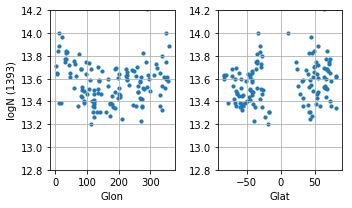

In [9]:
plt.figure(figsize=(5, 3))
plt.subplot(121)
plt.scatter(qtb_good['l'], qlogN[:, 0], s=10)
plt.xlabel('Glon')
plt.ylabel('logN (1393)')
plt.ylim(12.8, 14.2)
plt.grid('on')

plt.subplot(122)
plt.scatter(qtb_good['b'], qlogN[:, 0], s=10)
plt.xlabel('Glat')
plt.ylim(12.8, 14.2)
plt.grid('on')
plt.tight_layout()

In [10]:
delN = qlogN[:, 1] - qlogN[:, 0]
delN_err = np.sqrt(qlogNerr[:, 0]**2 + qlogNerr[:, 1]**2)
# delN_err = logNerr[:, 0]+logNerr[:, 1] # wakker use this 
nsig = delN/delN_err

ntag = np.zeros(nsig.size)
ntag[nsig>1] = 1          # N1402>N1393+sigma
ntag[tag_good == 1] = 1   # COS sat <= 0.1 

ntag[nsig<-1] = -1

print(ntag[ntag==0].size, ntag[ntag==1].size, ntag[ntag==-1].size)

119 11 2


In [11]:
print(qtb_good[ntag == -1])  # bad QSO, thrown out 
print(qlogN[ntag == -1])
print(qlogNerr[ntag==-1])

# 3C273 has a Lya blending in SiIV 1393, thus stronger than 1402 in logN, according to WK12. 

# PKS0405-123 has logN1393=13.46, consistent with Wakker+2012, but logN1402=13.24, about 0.16 dex lower than 
# WK+2012. The COS 1402 spec looks fine to me, while 1393 might have an overfit. So I think WK+2012's spec 
# of 1402 might have something weird going on. But they didn't show the original spectra, just the bin one
# so can't check :( 

nid      ID        RA      DEC       l        b      S/N    z   MM_Ep130 N_Ep130
--- ----------- -------- -------- -------- -------- ----- ----- -------- -------
 28       3C273 187.2779   2.0524 289.9508    64.36 105.7 0.158      0.0       7
145 PKS0405-123  61.9518 -12.1935 204.9271 -41.7563  78.2 0.572      4.6      18
[[14.20869856 13.81977701]
 [13.45619019 13.24754954]]
[[0.01055645 0.0026045 ]
 [0.00618124 0.01849297]]


In [12]:
print(qtb_good[ntag == 1])   # saturated QSO, lower limit 
print(qlogN[ntag==1])
print(delN_err[ntag==1])

nid            ID              RA      DEC    ... S/N    z   MM_Ep130 N_Ep130
--- ----------------------- -------- -------- ... ---- ----- -------- -------
  4                 RBS2005  351.476  21.8872 ... 14.6  0.12      0.0       8
  5              PG1211+143 183.5736  14.0537 ... 21.5  0.08      0.0       4
 21 2MASS-J14312586+2442203 217.8578  24.7057 ... 17.2 0.406     24.7       7
 66        IRAS-F04250-5718  66.5032 -57.2003 ... 83.1 0.104      0.0       8
106                  MRK841  226.005  10.4378 ... 18.2 0.036      0.0       4
115                  PDS456 262.0825 -14.2655 ...  9.3 0.184      0.0       4
139              PG1435-067 219.5673  -6.9724 ... 16.0 0.126      0.0       4
147             PKS0558-504  89.9475 -50.4478 ... 18.3 0.137      0.0       2
148              PKS1136-13 174.7946 -13.8456 ... 16.8 0.556      0.0       3
149             PKS2005-489 302.3558 -48.8316 ... 22.6 0.071      0.0       4
177          RXJ2139.7+0246 324.9341   2.7682 ... 14.8  0.26    

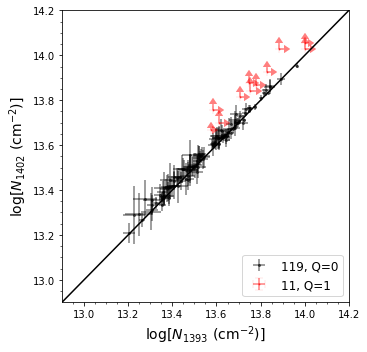

In [13]:
plt.figure(figsize=(5.2, 5))

n0 = ntag == 0
n1 = ntag == 1
plt.errorbar(qlogN[n0, 0], qlogN[n0, 1], xerr=qlogNerr[n0, 0], yerr=qlogNerr[n0, 1],
             fmt='o', color='k', markersize=2, alpha=0.5, label='%d, Q=0'%(qlogN[n0, 1].size))
plt.errorbar(qlogN[n1, 0], qlogN[n1, 1], xerr=qlogNerr[n1, 0], yerr=qlogNerr[n1, 1], 
             lolims=True, xlolims=True,
             fmt='.', markersize=2, color='r', alpha=0.5, 
             capthick=0.2, capsize=4, label='%d, Q=1'%(qlogN[n1, 1].size))

#nmin, nmax = 0.9e13, 1e14
nmin, nmax= 12.9, 14.2
plt.plot([nmin, nmax], [nmin, nmax], color='k')
plt.xlim(nmin, nmax)
plt.ylim(nmin, nmax)
plt.xlabel(r'log[$N_{1393}$ (cm$^{-2}$)]', fontsize=14)
plt.ylabel(r'log[$N_{1402}$ (cm$^{-2}$)]', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.minorticks_on()
plt.tight_layout()
plt.savefig('figs/fig3.pdf')

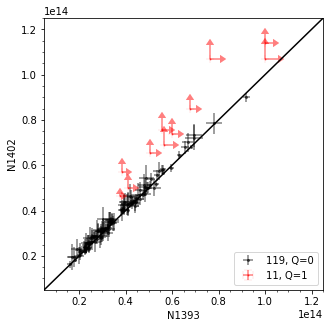

In [14]:
plt.figure(figsize=(5, 5))
plt.errorbar(qN[n0, 0], qN[n0, 1], xerr=qNerr[n0, 0], yerr=qNerr[n0, 1], 
             fmt='o', color='k', markersize=2, alpha=0.5, label='%d, Q=0'%(qlogN[n0, 1].size))
plt.errorbar(qN[n1, 0], qN[n1, 1], xerr=qNerr[n1, 0], yerr=qNerr[n1, 1], lolims=True, xlolims=True,
             fmt='.', markersize=2, color='r', alpha=0.5, 
             capthick=0.2, capsize=4, label='%d, Q=1'%(qlogN[n1, 1].size))

nmin, nmax = 5e12, 1.25e14
plt.plot([nmin, nmax], [nmin, nmax], color='k')
plt.xlim(nmin, nmax)
plt.ylim(nmin, nmax)
plt.xlabel('N1393')
plt.ylabel('N1402')
plt.legend(loc='lower right')
plt.minorticks_on()

Combine the SiIV1393 COS limit and logN difference to define the resolved and saturated QSO range 

In [15]:
def find_simbad_info(qso):
    from astropy.table import Table 
    #alltb = Table.read('/Users/Yong/Dropbox/HSLA_Feb16/targetlists/QSOALS_sample_AllSN5above_reformat.txt', 
    #                   format='ascii', delimiter=',')
    alltb = Table.read('cos-gal_mast_hlsp/cos-gal_qsos_list.fits', format='fits')
    ind = np.where(alltb['ID-HSLA-V1']==qso)[0][0]
    ra = alltb['RA(ICRS)'][ind]
    dec = alltb['DEC(ICRS)'][ind]
    z = alltb['z-SIMBAD'][ind]
    simid = alltb['ID-SIMBAD'][ind]
    
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
    l = coord.galactic.l.degree
    b = coord.galactic.b.degree
    return ra, dec, l, b, z, simid

#### Write a master fits table that includes linear and log column density values for each sightline

In [16]:
### The resolve data datatable.
ind_resolved = np.all([ntag==0, tag_good==0], axis=0) # tag_good is for flux ilmit of 0.1
                                                      # ntag is for N1393/N1402 comparison. 
sortind = np.argsort(snr_good[ind_resolved])[::-1]

qtb_resolved = qtb_good[ind_resolved][sortind]
snr_resolved = snr_good[ind_resolved][sortind]

qlogN_resolved = qlogN[ind_resolved][sortind]
qlogNerr_resolved = qlogNerr[ind_resolved][sortind]

qN_resolved = qN[ind_resolved][sortind]
qNerr_resolved = qNerr[ind_resolved][sortind]

qV_resolved = qV[ind_resolved][sortind]
qVerr_resolved = qVerr[ind_resolved][sortind]

In [17]:
### The saturated data value, Q=1
ind_sat = np.all([np.logical_not(ind_resolved), ntag!=-1], axis=0) # Q=1 target 
sortind = np.argsort(snr_good[ind_sat])[::-1]

qtb_sat = qtb_good[ind_sat][sortind]
snr_sat = snr_good[ind_sat][sortind]

qlogN_sat = qlogN[ind_sat][sortind]
qlogNerr_sat = qlogNerr[ind_sat][sortind]

qN_sat = qN[ind_sat][sortind]
qNerr_sat = qNerr[ind_sat][sortind]

qV_sat = qV[ind_sat][sortind]
qVerr_sat = qVerr[ind_sat][sortind]

In [18]:
### The bad data value, Q=-1
ind_odd = ntag ==-1 
qtb_odd = qtb_good[ind_odd]
snr_odd = snr_good[ind_odd]

qlogN_odd = qlogN[ind_odd]
qlogNerr_odd = qlogNerr[ind_odd]

qN_odd = qN[ind_odd]
qNerr_odd = qNerr[ind_odd]

qV_odd = qV[ind_odd]
qVerr_odd = qVerr[ind_odd]

In [19]:
# Now put all of them together. 

qid_all = np.concatenate([qtb_resolved['ID'], qtb_sat['ID'], qtb_odd['ID']]) # col2
nid_all = np.arange(qid_all.size)+1   # col1
snr_all = np.concatenate([snr_resolved, snr_sat, snr_odd])*np.sqrt(6)
qua_all = np.concatenate([np.zeros(len(qtb_resolved)), np.ones(len(qtb_sat)), np.zeros(len(qtb_odd))-1])

# [N, Nerr, logN, logNerr, V, Verr] for SiIV1393 line
il = 0
qN_LA = np.concatenate([qN_resolved[:, il], qN_sat[:, il], qN_odd[:, il]])
qNerr_LA = np.concatenate([qNerr_resolved[:, il], qNerr_sat[:, il], qNerr_odd[:, il]])

qlogN_LA = np.concatenate([qlogN_resolved[:, il], qlogN_sat[:, il], qlogN_odd[:, il]])
qlogNerr_LA = np.concatenate([qlogNerr_resolved[:, il], qlogNerr_sat[:, il], qlogNerr_odd[:, il]])

qV_LA = np.concatenate([qV_resolved[:, il], qV_sat[:, il], qV_odd[:, il]])
qVerr_LA = np.concatenate([qVerr_resolved[:, il], qVerr_sat[:, il], qV_odd[:, il]])

# Same for the SiIV 1402 line
il = 1
qN_LB = np.concatenate([qN_resolved[:, il], qN_sat[:, il], qN_odd[:, il]])
qNerr_LB = np.concatenate([qNerr_resolved[:, il], qNerr_sat[:, il], qNerr_odd[:, il]])

qlogN_LB = np.concatenate([qlogN_resolved[:, il], qlogN_sat[:, il], qlogN_odd[:, il]])
qlogNerr_LB = np.concatenate([qlogNerr_resolved[:, il], qlogNerr_sat[:, il], qlogNerr_odd[:, il]])

qV_LB = np.concatenate([qV_resolved[:, il], qV_sat[:, il], qV_odd[:, il]])
qVerr_LB = np.concatenate([qVerr_resolved[:, il], qVerr_sat[:, il], qV_odd[:, il]])

## coordinate information 

siml_all = np.zeros(qid_all.size)  # col3
simb_all = np.zeros(qid_all.size)  # col4
simz_all = np.zeros(qid_all.size)  # col5
simra_all = np.zeros(qid_all.size)
simdec_all = np.zeros(qid_all.size)
simid_all = []

for iq in range(qid_all.size):
    qso = qid_all[iq]
    simra, simdec, siml, simb, simz, simid = find_simbad_info(qso)
    simra_all[iq] = simra
    simdec_all[iq] = simdec
    siml_all[iq] = siml
    simb_all[iq] = simb 
    simz_all[iq] = simz
    simid_all.append(simid)
               
simid_all = np.asarray(simid_all)  # col the last one

In [20]:
from astropy.table import Table
master = Table([nid_all, qid_all, siml_all, simb_all, simra_all, simdec_all, simz_all, snr_all, qua_all, 
                qlogN_LA, qlogNerr_LA, qN_LA, qNerr_LA, qV_LA, qVerr_LA, 
                qlogN_LB, qlogNerr_LB, qN_LB, qNerr_LB, qV_LB, qVerr_LB, 
                simid_all], 
                names=('No.', 'ID-HSLA-V1', 'Glon', 'Glat', 'RA(ICRS)', 'DEC(ICRS)', 'z', 'SNR-SiIV', 'Q', 
                       'logN_1393', 'logNsig_1393', 'N_1393', 'Nsig_1393', 'V_1393', 'Vsig_1393', 
                       'logN_1402', 'logNsig_1402', 'N_1402', 'Nsig_1402', 'V_1402', 'Vsig_1402', 
                       'ID-SIMBAD'), 
                meta={'name': 'Zheng+2018 MW CGM Table 1'})

In [21]:
master['ID-HSLA-V1'].format = 's'
master['Glon'].format = '10.4f'
master['Glat'].format = '10.4f'
master['RA(ICRS)'].format = '10.4f'
master['DEC(ICRS)'].format = '10.4f'
master['z'].format = '7.4f'
master['SNR-SiIV'].format = '5.1f'

master['logN_1393'].format = '5.2f'
master['logNsig_1393'].format = '5.2f'
master['N_1393'].format = '7.4e'
master['Nsig_1393'].format = '7.4e'
master['V_1393'].format = '5.1f'
master['Vsig_1393'].format = '5.1f'

master['logN_1402'].format = '5.2f'
master['logNsig_1402'].format = '5.2f'
master['N_1402'].format = '7.4e'
master['Nsig_1402'].format = '7.4e'
master['V_1402'].format = '5.1f'
master['Vsig_1402'].format = '5.1f'

In [22]:
master['Glon'].unit = 'degree'
master['Glat'].unit = 'degree'
master['RA(ICRS)'].unit = 'degree'
master['DEC(ICRS)'].unit = 'degree'

master['N_1393'].unit = 'cm^-2'
master['Nsig_1393'].unit = 'cm^-2'
master['V_1393'].unit = 'km/s'
master['Vsig_1393'].unit = 'km/s'

master['N_1402'].unit = 'cm^-2'
master['Nsig_1402'].unit = 'cm^-2'
master['V_1402'].unit = 'km/s'
master['Vsig_1402'].unit = 'km/s'

In [23]:
master.write('tables/Zheng18_Table1.fits')
master.show_in_browser(jsviewer=True)